<a href="https://colab.research.google.com/github/dylanblandino12/marketing-analytics-end-to-end/blob/main/python/01_funnel_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# =====================================
# File: 01_funnel_analysis.ipynb
# Purpose: Analyze session-level conversion funnel and identify major drop-off points.
# Dataset: Google Analytics Public Dataset
# Tools: Python (pandas), BigQuery, Google Colab
# =====================================


## Notebook Overview

This notebook focuses on analyzing the conversion funnel at the session level.
Using event-based data, we evaluate how users progress through key funnel stages
and identify where the largest drop-offs occur.


In [1]:
# Authenticate with Google to access BigQuery

from google.colab import auth
auth.authenticate_user()


In [2]:
# Import libraries

import pandas as pd
from google.cloud import bigquery
import matplotlib.pyplot as plt


In [4]:
#Initialize BigQuery client

client = bigquery.Client(project="marketing-analytics-483016")


## Load Funnel Event Data

The funnel dataset contains event-level records associated with user sessions.
Each row represents a specific ecommerce action within a session and will be
used to analyze user progression through the conversion funnel.


In [6]:
#Create Load Funnel DataFrame at session level

query_load_funnel = """
SELECT
session_id,
ecommerce_action_type
FROM `marketing_analytics.vw_events_funnel`
WHERE ecommerce_action_type IN ('2', '3', '5', '6')
"""

df_funnel = client.query(query_load_funnel).to_dataframe()

df_funnel.head()


,session_id,ecommerce_action_type
0,0266551908038855770-1479469344,2
1,3852647832475967320-1479493141,2
2,2673852251534577712-1479493416,2
3,581826404657964430-1479508174,2
4,2689694350055032196-1479479255,2


## Funnel Step Mapping

Ecommerce action codes are mapped to descriptive funnel stage labels to improve
readability and interpretation of the funnel analysis. This step does not alter
the underlying data, only its representation.


In [8]:
#Map Funnel Steps

dic_funnel_steps = {
    '2': 'Product detail view',
    '3': 'Add to cart',
    '5': 'Checkout',
    '6': 'Completed purchase'
}

df_funnel['funnel_step'] = df_funnel['ecommerce_action_type'].map(dic_funnel_steps)

df_funnel[['ecommerce_action_type', 'funnel_step']].head()


,ecommerce_action_type,funnel_step
0,2,Product detail view
1,2,Product detail view
2,2,Product detail view
3,2,Product detail view
4,2,Product detail view


## Session-Level Funnel Counts

To accurately measure funnel progression and drop-off, each session is counted
once per funnel stage. This approach avoids inflating funnel steps due to multiple
events occurring within the same session.


In [24]:
#Session-level funnel counts

funnel_sessions = (
    df_funnel
    .dropna(subset=['funnel_step'])
    .groupby('funnel_step')['session_id']
    .nunique()
    .reset_index(name='sessions')
)

print(funnel_sessions)

           funnel_step  sessions
0          Add to cart     50098
1             Checkout     22386
2   Completed purchase     11551
3  Product detail view    124053


## Funnel Visualization

The following visualization illustrates the number of unique sessions reaching
each funnel stage. The chart helps highlight where the largest drop-offs occur
across the conversion funnel.


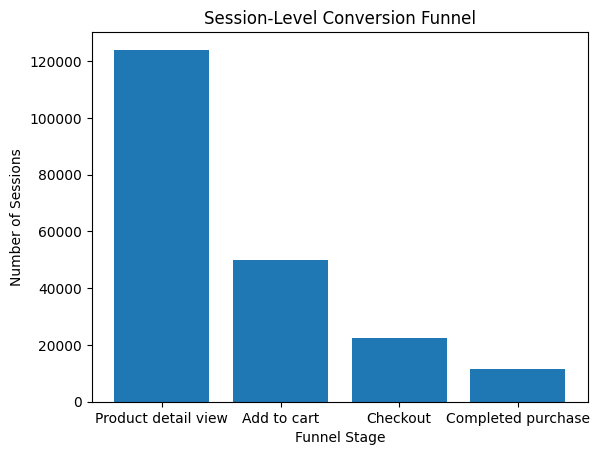

In [25]:
# Define the logical order of the funnel
funnel_order = [
    'Product detail view',
    'Add to cart',
    'Checkout',
    'Completed purchase'
]

# Reorder the dataframe according to funnel order
funnel_sessions['funnel_step'] = pd.Categorical(
    funnel_sessions['funnel_step'],
    categories=funnel_order,
    ordered=True
)

funnel_sessions = funnel_sessions.sort_values('funnel_step')

# Create bar chart
plt.figure()
plt.bar(funnel_sessions['funnel_step'], funnel_sessions['sessions'])
plt.xlabel('Funnel Stage')
plt.ylabel('Number of Sessions')
plt.title('Session-Level Conversion Funnel')
plt.show()


## Insight

The conversion funnel shows a significant drop-off between product detail views
and add-to-cart actions, indicating early-stage friction before users demonstrate
strong purchase intent. Additional drop-off during checkout suggests potential
optimization opportunities in the purchase completion flow.
